# Previsão de faturamento - Modelo autorregressivo ajustado ao faturamento total

<sub>Projeto para a disciplina de **Estatística** (Módulo 4) do Data Science Degree (turma de julho de 2020)</sub>

## Equipe

* Felipe Lima de Oliveira
* Mário Henrique Romagna Cesa
* Tsuyioshi Valentim Fukuda
* Fernando Raineri Monari

Link para [projeto no Github](https://github.com/flimao/case-previsao-faturamento)

## Introdução

Este notebook contém o modelo ajustado para o faturamento total mês a mês, somando todos os produtos

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# modelos
from pmdarima.arima import auto_arima
from pmdarima.arima.arima import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# metricas 
from sklearn.metrics import mean_absolute_percentage_error as smape, mean_squared_error as smse, mean_absolute_error as smae 

# importar scripts
cwd = os.getcwd()
os.chdir("../")
import py_scripts.plots, py_scripts.transform, py_scripts.metrics

os.chdir(cwd)

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = (10, 4)

## Importação dos dados

In [2]:
ts_raw = pd.read_csv(r'../data/sim_ts_limpo.csv')
tsd, tswide = py_scripts.transform.pipeline(ts_raw)
fat_total = tswide.sum(axis = 'columns').dropna()

In [3]:
fat_total

date
2009-12-01    1.006195e+09
2010-01-01    9.993524e+08
2010-02-01    1.000041e+09
2010-03-01    9.905806e+08
2010-04-01    9.947466e+08
                  ...     
2021-06-01    2.086224e+09
2021-07-01    2.073233e+09
2021-08-01    2.101590e+09
2021-09-01    2.179518e+09
2021-10-01    2.193340e+09
Freq: MS, Length: 143, dtype: float64

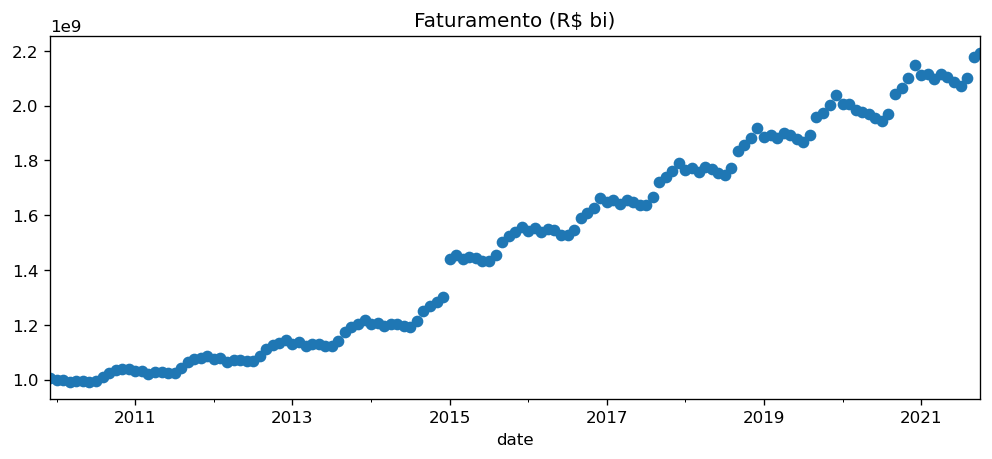

In [4]:
fat_total.plot(linestyle = '', marker = 'o')
plt.title('Faturamento (R$ bi)')
plt.show()

## Modelo autorregressivo - Faturamento total

Para analisar e prever essa série temporal, é necessário um modelo mais completo. Utilizaremos aqui um modelo autorregressivo integrado de média móvel com sazonalidade - **SARIMA**.

OBS.: o modelo completo chama-se SARIMAX; o `X` adicional permite a modelagem de variáveis exógenas. No entanto, não utilizaremos variáveis exógenas neste caso.

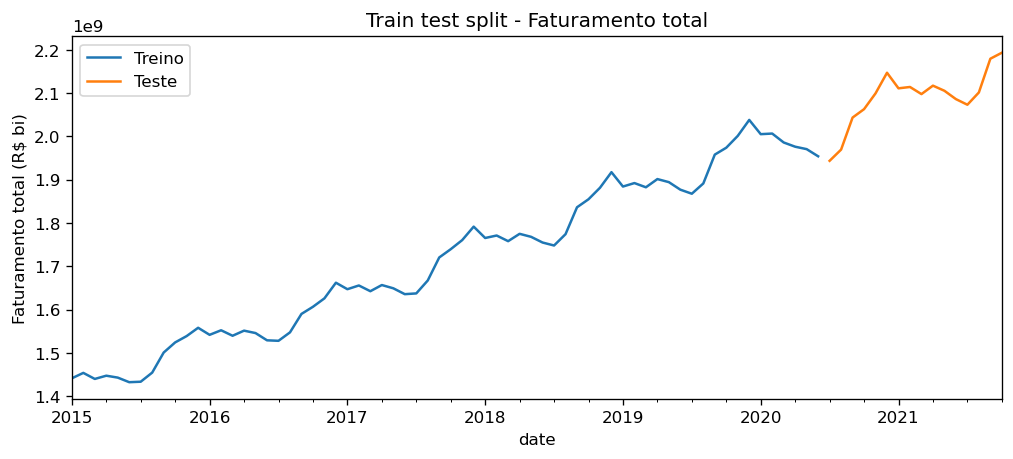

In [5]:
# excluindo o período pré-2015

test_begin = '2020-01-01'
fat_modelo = fat_total['2015-01-01':]

total_train = fat_modelo[:test_begin].iloc[:-1]
total_test = fat_modelo[test_begin:]


train_test_split_idx = int(fat_modelo.shape[0] * 0.8 + 1)
total_train = fat_modelo[:train_test_split_idx]
total_test = fat_modelo[train_test_split_idx:]

total_train.plot(label = 'Treino')
total_test.plot(label = 'Teste')
plt.title('Train test split - Faturamento total')
plt.ylabel('Faturamento total (R$ bi)')
plt.legend()
plt.show()

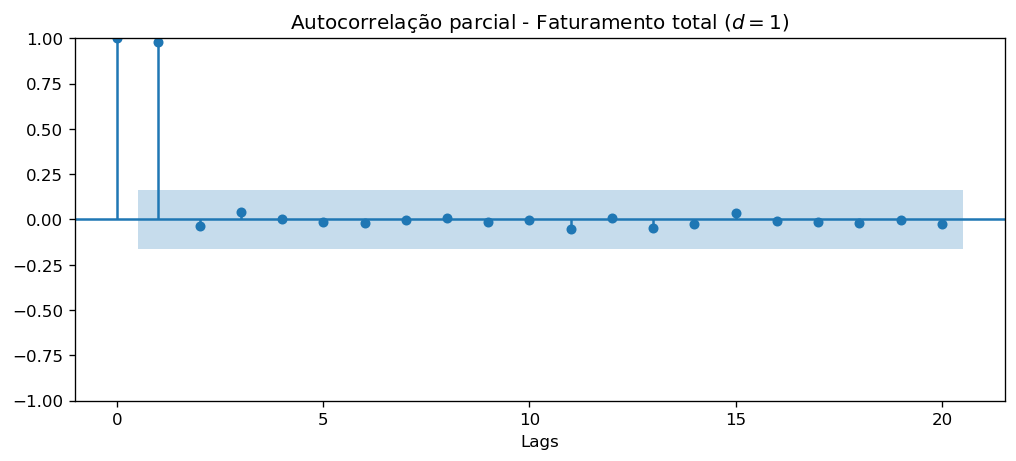

In [6]:
fig = plt.figure()
ax = fig.gca()
plot_pacf(fat_total, lags = 20, method = 'ywm', ax = ax)
ax.set_xlabel('Lags')
ax.set_title(f"Autocorrelação parcial - Faturamento total ($d = 1$)")
plt.show()

In [7]:
# arimas = {}
# arimas['total'] = auto_arima(
#     y = total_train,
#     start_p = 1, max_p = 3,
#     d = None, max_d = 4,
#     start_q = 1, max_q = 3,
#     start_P = 1, max_P = 3,
#     D = None, max_D = 4,
#     start_Q = 1, max_Q = 3,
#     #max_order = 6,
#     m = 12,
#     seasonal = True
#     #alpha = 0.05
# )

In [8]:
modelo = ARIMA(order = (0, 2, 0), seasonal_order = (1, 1, 1, 12), with_intercept = True).fit(y = total_train)

C:\ProgramData\Anaconda3\envs\dsd\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\ProgramData\Anaconda3\envs\dsd\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [9]:
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   66
Model:             SARIMAX(0, 2, 0)x(1, 1, [1], 12)   Log Likelihood                -895.646
Date:                              Thu, 18 Nov 2021   AIC                           1799.292
Time:                                      00:03:49   BIC                           1807.097
Sample:                                           0   HQIC                          1802.285
                                               - 66                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5.528e+04   1.38e-07   4.01e+11      0.000    5.53e+04    5.53e+04
ar.S.L12       0.7644      0.318      2.407      0.016       0.142       1.387
ma.S.L12      -0.7437      0.299     -2.487      0.013      -1.330      -0.158
sigma2      5.863e+13   4.34e-15   1.35e+28      0.000    5.86e+13    5.86e+13
===================================================================================
Ljung-Box (L1) (Q):                   2.85   Jarque-Bera (JB):                52.52
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               2.47   Skew:                             1.11
Prob(H) (two-sided):                  0.07   Kurtosis:                         7.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.29e+43. Standard errors may be unstable.
"""

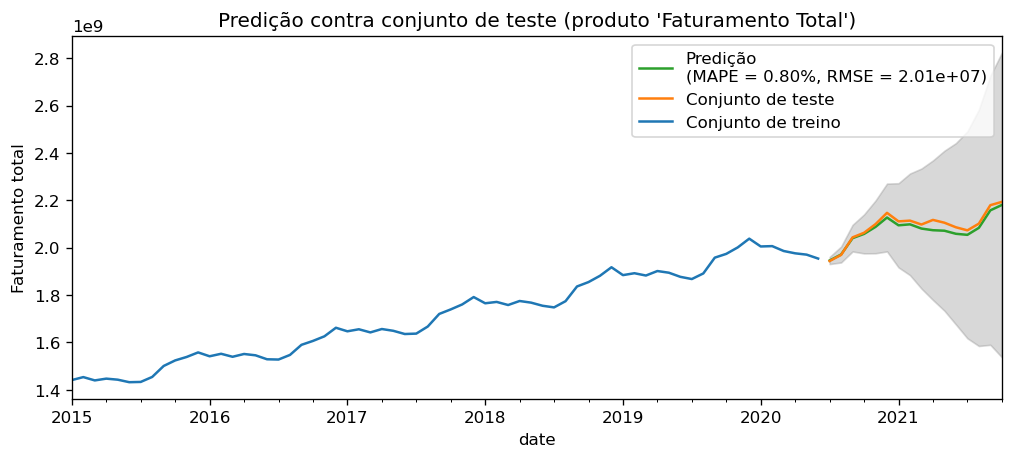

In [10]:
preds = py_scripts.plots.ajuste_grafico(
    modelo = modelo, 
    produto = 'Faturamento Total',
    serie_treino = total_train,
    serie_teste = total_test,
    ci = True,
    in_sample = False,
    preds_metrics = True
)

Vamos aplicar algumas métricas ao modelo:

In [11]:
kwargs_total = dict(
    y_true = total_test,
    y_pred = preds
)

metricas = dict(
    total = dict(
        mape = smape(**kwargs_total),
        rmse = np.sqrt(smse(**kwargs_total)),
        mae = smae(**kwargs_total)
    )
)

mape = metricas['total']['mape']
rmse = metricas['total']['rmse']
mae = metricas['total']['mae']

print(f'MAPE: {mape:.3%}')
print(f'RMSE: {rmse:.3e}')
print(f' MAE: {mae:.3e}')

MAPE: 0.797%
RMSE: 2.015e+07
 MAE: 1.683e+07


Vamos salvar o modelo atual para o faturamento total.

In [12]:
with open(r'../models/total_arima.pickle', 'wb') as modelo_total:
    pickler = pickle.Pickler(file = modelo_total)
    #pickler.dump(modelo)
